In [1]:
from numpy import pi
from modsim_local import *

In [2]:
radius_disk = 0.5     # m
mass_disk = 7 # kg
radius_pot= 0.4 # m
mass_pot = 0.3 # kg
force = 2 # N

theta_push = 0.5 * pi # rad
theta_test = 1.5 * pi # rad
theta_target = pi

In [3]:
I_disk = mass_disk * radius_disk**2 / 2 # kg*m^2
I_pot = mass_pot * radius_pot**2 / 2 # kg*m^2
I_total = I_disk + I_pot # kg*m^2

In [4]:
torque_friction = 0.3 # N*m

In [5]:
init = State(theta=0, omega = 0)

In [6]:
system = System(init = init,
                torque_friction = torque_friction,
                I_total = I_total,
                radius_disk = radius_disk,
                mass_disk = mass_disk,
                radius_pot = radius_pot,
                mass_pot = mass_pot,
                force = force,
                theta_push = theta_push,
                theta_test = theta_test,
                theta_target = theta_target,
                t_end = 20)

In [7]:
def slope_func(t, state, system):
    theta, omega = state
    force = system.force
    torque_friction = system.torque_friction
    
    torque = force*radius_disk - torque_friction
    alpha = torque / I_total
    dtheta = omega
    domega = alpha
    return dtheta, domega

In [8]:
slope_func(0, system.init, system)

(0, 0.778642936596218)

In [9]:
def event_func1(t, state, system):
    theta, omega = state
    return theta - theta_push

In [10]:
event_func1(0, system.init, system)

-1.5707963267948966

In [11]:
results1, details1 = run_solve_ivp(system, slope_func,
                                   events=event_func1)
details1.message

'A termination event occurred.'

In [12]:
results1.tail()

,theta,omega
1.928311,1.447646,1.501465
1.948397,1.477962,1.517106
1.968484,1.508593,1.532746
1.988570,1.539537,1.548386
2.008657,1.570796,1.564027


In [13]:
t_2 = results1.index[-1]
init2 = results1.iloc[-1]

In [14]:
system2 = system.set(init = init2, force = 0, t_0 =  t_2)

In [15]:
def event_func2(t, state, system):
    theta, omega = state
    return omega

In [16]:
event_func2(system2.t_0, system2.init, system2)

1.564026511725507

In [17]:
results2, details2 = run_solve_ivp(system2, slope_func,
                                   events=event_func2)
details2.message

'A termination event occurred.'

In [18]:
results = pd.concat([results1, results2])

In [19]:
results.tail()

,theta,omega
6.508048,5.230123,6.256106e-02
6.554917,5.232689,4.692080e-02
6.601786,5.234522,3.128053e-02
6.648654,5.235621,1.564027e-02
6.695523,5.235988,2.220446e-16


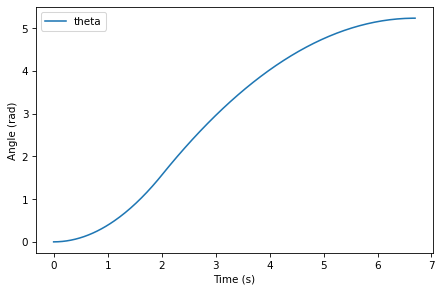

In [20]:
results.theta.plot(label='theta')
decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')

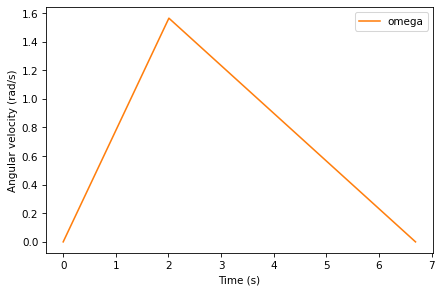

In [21]:
results.omega.plot(label='omega', color='C1')
decorate(xlabel='Time (s)',
             ylabel='Angular velocity (rad/s)')

In [22]:
def run_two_phases(force, torque_friction, system):
    # put the specified parameters into the System object
    system1 = system.set(force=force, 
                         torque_friction=torque_friction)

    # run phase 1
    results1, details1 = run_solve_ivp(system1, slope_func, 
                                       events=event_func1)

    # get the final state from phase 1
    t_2 = results1.index[-1]
    init2 = results1.iloc[-1]
    
    # run phase 2
    system2 = system1.set(t_0=t_2, init=init2, force=0)
    results2, details2 = run_solve_ivp(system2, slope_func, 
                                       events=event_func2)
    
    # combine and return the results
    results = pd.concat([results1, results2])
    return results

In [23]:
force = 2
torque_friction = 0.3
results = run_two_phases(force, torque_friction, system)
results.tail()

,theta,omega
6.508048,5.230123,6.256106e-02
6.554917,5.232689,4.692080e-02
6.601786,5.234522,3.128053e-02
6.648654,5.235621,1.564027e-02
6.695523,5.235988,2.220446e-16


In [24]:
def error_func1(torque_friction, system):
    force = system.force
    results = run_two_phases(force, torque_friction, system)
    theta_final = results.iloc[-1].theta
    print(torque_friction, theta_final)
    return theta_final - theta_test

In [25]:
guess1 = 0.3
error_func1(guess1, system)

0.3 5.235987755982986


0.5235987755982965

In [26]:
guess2 = 0.4
error_func1(guess2, system)

0.4 3.9269908169872387


-0.7853981633974509

In [27]:
res = root_scalar(error_func1, system, bracket=[guess1, guess2])

0.3 5.235987755982986
0.3 5.235987755982986
0.4 3.9269908169872387
0.3399999999999998 4.619989196455574
0.3339999999999996 4.702983014355983
0.33333199999999996 4.712407830016002
0.333348666601 4.712172221390802


In [28]:
actual_friction = res.root
actual_friction

0.33333199999999996

In [29]:
from matplotlib.patches import Circle
from matplotlib.pyplot import gca, axis

def draw_func(t, state):
    theta, omega = state
    
    # draw a circle for the table
    circle1 = Circle([0, 0], radius_disk)
    gca().add_patch(circle1)
    
    # draw a circle for the teapot
    center = pol2cart(theta, radius_pot)
    circle2 = Circle(center, 0.05, color='C1')
    gca().add_patch(circle2)

    axis('equal')

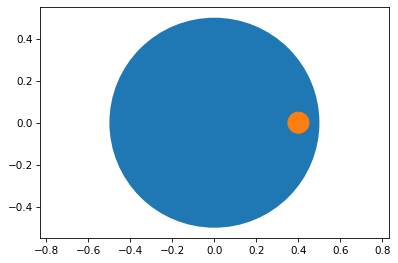

In [30]:
state = results.iloc[0]
draw_func(0, state)